# Music-Genre-Classifier RNN
Kaito Minami

In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import StandardScaler
import audioread
from sklearn.preprocessing import StandardScaler
# from pydub import AudioSegment


## 1. Data Processing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the datasets
file_30_sec = '/content/drive/MyDrive/Colab Notebooks/GTZAN/features_30_sec.csv'
file_3_sec = '/content/drive/MyDrive/Colab Notebooks/GTZAN/features_3_sec.csv'

df_30_sec = pd.read_csv(file_30_sec)
df_3_sec = pd.read_csv(file_3_sec)

In [4]:
# Function to extract Mel spectrogram features
def extract_mel_spectrogram(file_path, sr=22050, n_mels=128):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr)
        # Extract Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_flattened = mel_spectrogram_db.flatten()  # Flatten for use in ML models
    except (FileNotFoundError, librosa.util.exceptions.LibrosaError, audioread.NoBackendError):
        print(f"Audio file {file_path} not found or cannot be processed. Using CSV features instead.")
        mel_spectrogram_flattened = None
    return mel_spectrogram_flattened

# Splitting the dataset into training, validation, and test sets
def split_data(df, test_size=0.2, val_size=0.2):
    train_val, test = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=val_size, stratify=train_val['label'], random_state=42)
    return train, val, test

# Function to process the entire dataset and extract features
def process_dataset(df, audio_directory, feature_type='mel'):
    features = []
    labels = []
    for idx, row in df.iterrows():
        file_path = os.path.join(audio_directory, row['label'], row['filename'])
        if feature_type == 'mel':
            feature_vector = extract_mel_spectrogram(file_path)
        elif feature_type == 'wavelet':
            feature_vector = extract_wavelet_features(file_path)
        elif feature_type == 'chroma':
            feature_vector = extract_chroma_features(file_path)
        else:
            raise ValueError("Invalid feature type. Choose from 'mel', 'wavelet', 'chroma'.")

        # If audio features cannot be extracted, use CSV features
        if feature_vector is None:
            feature_vector = row.drop(['label']).filter(regex='^(?!filename)').values.astype(np.float32)
        features.append(feature_vector)
        labels.append(row['label'])

    # Ensure all feature vectors have the same length by padding or truncating
    max_length = max(len(f) for f in features)
    features = np.array([np.pad(f, (0, max_length - len(f)), 'constant') if len(f) < max_length else f[:max_length] for f in features])
    return features, np.array(labels)

In [12]:
# Standardizing dataset before splitting
scaler = StandardScaler()
df_30_sec_numeric = df_30_sec.select_dtypes(include=['float64', 'int64']).copy()
df_30_sec[df_30_sec_numeric.columns] = scaler.fit_transform(df_30_sec_numeric)

df_3_sec_numeric = df_3_sec.select_dtypes(include=['float64', 'int64']).copy()
df_3_sec[df_3_sec_numeric.columns] = scaler.fit_transform(df_3_sec_numeric)

# Splitting the dataset for 30-sec
train_df_30_sec, val_df_30_sec, test_df_30_sec = split_data(df_30_sec)

# Extract and process features for 30-sec dataset
audio_directory = '/content/drive/MyDrive/Colab Notebooks/GTZAN/genres_original'

# Mel Spectrogram Features
train_mel_features, train_mel_labels = process_dataset(train_df_30_sec, audio_directory, feature_type='mel')
val_mel_features, val_mel_labels = process_dataset(val_df_30_sec, audio_directory, feature_type='mel')
test_mel_features, test_mel_labels = process_dataset(test_df_30_sec, audio_directory, feature_type='mel')

<ipython-input-4-53b740a4d696>:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio file /content/drive/MyDrive/Colab Notebooks/GTZAN/genres_original/jazz/jazz.00054.wav not found or cannot be processed. Using CSV features instead.


## 2. LSTM model

In [6]:
def one_hot(genre_strings):
    genre_list = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

    y_one_hot = np.zeros((genre_strings.shape[0], len(genre_list)))
    for i, genre_string in enumerate(genre_strings):
        index = genre_list.index(genre_string)
        y_one_hot[i, index] = 1
    return y_one_hot

In [13]:
# adds timeseries sequence dimension to X and one-hot encode y
print(train_mel_features.shape)
train_mel_features = train_mel_features.reshape(train_mel_features.shape[0], 1, train_mel_features.shape[1])
train_mel_labels = one_hot(train_mel_labels)

val_mel_features = val_mel_features.reshape(val_mel_features.shape[0], 1, val_mel_features.shape[1])
val_mel_labels = one_hot(val_mel_labels)

test_mel_features = test_mel_features.reshape(test_mel_features.shape[0], 1, test_mel_features.shape[1])
test_mel_labels = one_hot(test_mel_labels)

(640, 168960)


In [14]:
# Model building
model = Sequential()
input_shape = (train_mel_features.shape[1], train_mel_features.shape[2])

model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=input_shape))
model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(units=10, activation="softmax"))

# Model compiling
opt = Adam()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

# Model training
batch_size = 35  # num of training examples per minibatch
num_epochs = 400

print(train_mel_features.shape, train_mel_labels.shape)

history = model.fit(
    train_mel_features,
    train_mel_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(val_mel_features, val_mel_labels)
)

# Testing
score, accuracy = model.evaluate(
    test_mel_features, test_mel_labels, batch_size=batch_size, verbose=1
)
print("Test loss:  ", score)
print("Test accuracy:  ", accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 128)              │      86,573,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,594,506 (330.33 MB)

 Trainable params: 86,594,506 (330.33 MB)

 Non-trainable params: 0 (0.00 B)

(640, 1, 168960) (640, 10)
Epoch 1/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.0777 - loss: 2.3208 - val_accuracy: 0.0938 - val_loss: 2.3069
Epoch 2/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.1154 - loss: 2.3022 - val_accuracy: 0.1000 - val_loss: 2.3037
Epoch 3/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.0882 - loss: 2.3044 - val_accuracy: 0.1000 - val_loss: 2.3031
Epoch 4/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.0913 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 5/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.1071 - loss: 2.3041 - val_accuracy: 0.1000 - val_loss: 2.3038
Epoch 6/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.1027 - loss: 2.3004 - val_accuracy: 0.1000 - val_loss: 2.3033
Epoch 7/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.0948 - loss: 2.3041 - val_accuracy: 0.1000 - val_loss: 2.3035
Epoch 8/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.11

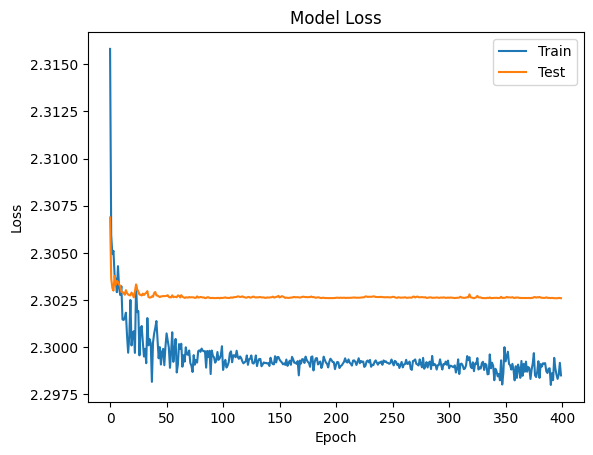

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

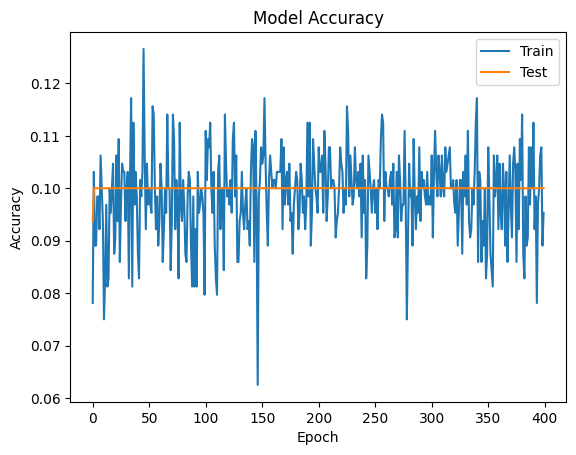

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()